<a href="https://colab.research.google.com/github/divyam123-EECS-Physics/NetLoadForecastingScripts/blob/pytorch1/Universal_PyTorch_Manual_Tuning_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports and Utilities

In [2]:

import pandas as pd
!pip install solarforecastarbiter
!pip install TimezoneFinder

import numpy as np
import matplotlib.pyplot as plt
from timezonefinder import TimezoneFinder
import solarforecastarbiter.metrics
from solarforecastarbiter.metrics.probabilistic import continuous_ranked_probability_score,crps_skill_score
import solarforecastarbiter.reference_forecasts
from solarforecastarbiter.reference_forecasts.persistence import persistence_probabilistic_timeofday, persistence_probabilistic
# from gluonts.mx.model.deep_npts import DeepNPTSEstimator
import torch
import scipy as sp

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


In [3]:
np.random.seed(786)
torch.manual_seed(786)


In [4]:
from timezonefinder import TimezoneFinder
states = {
    'hi': {
        "state_location":'hawaii',
        "lat":21.446911,
        "lon":-158.188736,
        "elevation":4.0,
        "fresh_data_time":'12',
        "reference_id":"c639b1f3-eb8f-11ed-802e-aec5a60999dc",
        "name":"Waianae, HI Substation",    },
    'or': {
        "state_location":'oregon',
        "lat":45.114559,
        "lon":-123.204903,
        "elevation":50.0,
        "fresh_data_time":'12',
        "reference_id":"5ebb4527-edbd-11ed-bf8d-128dcacebd72",
        "name":"Amity, OR Substation",
    },
    'tx': {
         "state_location":'texas',
        "lat":29.424122,
        "lon":-98.493629,
        "elevation":200.0,
        "fresh_data_time":'06',
        "reference_id":"8568f10f-eb8f-11ed-a556-128dcacebd72",
        "name":"San Antonio, TX Substation",

    },
    'ga': {
        "state_location":'georgia',
        "lat":31.044241,
        "lon":-84.879128,
        "elevation":0.0,
        "fresh_data_time":'06',
        "reference_id":"90c2a42c-f0ad-11ed-94b4-5edf5e2b3336",
        "name":"Donalsonville, GA Substation"
    },

}

tf = TimezoneFinder(in_memory=True)
for state in states:
  local_time_zone = tf.timezone_at(lng = states[state]['lon'], lat = states[state]['lat'])
  states[state]['local_time_zone'] = local_time_zone


tx_lon = -98.493629
tx_lat = 29.424122
ga_lon = -84.879128
ga_lat = 31.044241
or_lon = -123.204903
or_lat = 45.114559
hi_lat = 21.446911
hi_lon = -158.188736



from solarforecastarbiter.io import api
def upload_function(data_df, state = 'hi'):
    email = 'nlf2023-coral@forecastarbiter.com'
    pwd =  'T3&b@O*KiGf$a@!@3LBv'
    token = api.request_cli_access_token(email, pwd)
    session = api.APISession(token, base_url="https://api.forecastarbiter.com")
    if state == 'hi':

        hawaii_forecast_ids = [
           ["60534840-0044-11ee-8096-22bbbfba48a8", "p0"],
           ["60551d2e-0044-11ee-aea4-22bbbfba48a8", "p10"],
           ["60577a7c-0044-11ee-9d93-22bbbfba48a8", "p20"],
           ["6059b4ae-0044-11ee-b9f7-22bbbfba48a8", "p30"],
           ["605c7e09-0044-11ee-88c5-22bbbfba48a8", "p40"],
           ["605f5aad-0044-11ee-a68f-22bbbfba48a8", "p50"],
           ["6061a141-0044-11ee-b645-22bbbfba48a8", "p60"],
           ["6063f5d3-0044-11ee-a725-22bbbfba48a8", "p70"],
           ["606656a8-0044-11ee-aca6-22bbbfba48a8", "p80"],
           ["6069aa58-0044-11ee-b4a8-22bbbfba48a8", "p90"],
           ["606c387a-0044-11ee-92ea-22bbbfba48a8", "p100"],
        ]
        for uuid, col in hawaii_forecast_ids:
            upload_df = data_df[col]
            upload_df = upload_df.rename('value')
            session.post_probabilistic_forecast_constant_value_values(uuid, upload_df)

        return
    if state == 'tx':
        tx_forecast_ids = [
           ["51936f7f-0044-11ee-8006-22bbbfba48a8", "p0"],
           ["5195a4a9-0044-11ee-9abe-22bbbfba48a8", "p10"],
           ["5199b969-0044-11ee-8c5b-22bbbfba48a8", "p20"],
           ["519be6af-0044-11ee-aa1b-22bbbfba48a8", "p30"],
           ["519e4691-0044-11ee-ace3-22bbbfba48a8", "p40"],
           ["51a07836-0044-11ee-b70a-22bbbfba48a8", "p50"],
           ["51a2b229-0044-11ee-9369-22bbbfba48a8", "p60"],
           ["51a54811-0044-11ee-9b1c-22bbbfba48a8", "p70"],
           ["51a78587-0044-11ee-ac5f-22bbbfba48a8", "p80"],
           ["51a96889-0044-11ee-95de-22bbbfba48a8", "p90"],
           ["51ac716f-0044-11ee-96a0-22bbbfba48a8", "p100"],
        ]
        for uuid, col in tx_forecast_ids:
            upload_df = data_df[col]
            upload_df = upload_df.rename('value')
            session.post_probabilistic_forecast_constant_value_values(uuid, upload_df)

        return
    if state == 'or':

        or_forecast_ids = [
           ["58ea38ee-0044-11ee-abf9-aa678857fb1c", "p0"],
           ["58ecd0ac-0044-11ee-96ef-aa678857fb1c", "p10"],
           ["58efa6af-0044-11ee-a87e-aa678857fb1c", "p20"],
           ["58f2856f-0044-11ee-94d6-aa678857fb1c", "p30"],
           ["58f4d11c-0044-11ee-80ca-aa678857fb1c", "p40"],
           ["58f792d8-0044-11ee-869d-aa678857fb1c", "p50"],
           ["58fa355e-0044-11ee-881a-aa678857fb1c", "p60"],
           ["58fc98a1-0044-11ee-b2cb-aa678857fb1c", "p70"],
           ["58ff236c-0044-11ee-ba4c-aa678857fb1c", "p80"],
           ["5901b51f-0044-11ee-aae2-aa678857fb1c", "p90"],
           ["59045e2b-0044-11ee-8914-aa678857fb1c", "p100"],
        ]
        for uuid, col in or_forecast_ids:
            upload_df = data_df[col]
            upload_df = upload_df.rename('value')
            session.post_probabilistic_forecast_constant_value_values(uuid, upload_df)

        return
    if state == 'ga':

        ga_forecast_ids = [
           ["493ba331-0044-11ee-936c-aa678857fb1c", "p0"],
           ["493e3bce-0044-11ee-bdf4-aa678857fb1c", "p10"],
           ["4940a921-0044-11ee-8e27-aa678857fb1c", "p20"],
           ["49431d34-0044-11ee-a476-aa678857fb1c", "p30"],
           ["4945f80a-0044-11ee-8674-aa678857fb1c", "p40"],
           ["49489e6d-0044-11ee-8ce3-aa678857fb1c", "p50"],
           ["494b350e-0044-11ee-b5bc-aa678857fb1c", "p60"],
           ["494fe072-0044-11ee-bb2d-aa678857fb1c", "p70"],
           ["4952cab3-0044-11ee-afa5-aa678857fb1c", "p80"],
           ["4955940c-0044-11ee-a0c7-aa678857fb1c", "p90"],
           ["495827d0-0044-11ee-83b0-aa678857fb1c", "p100"],
        ]

        for uuid, col in ga_forecast_ids:
            upload_df = data_df[col]
            upload_df = upload_df.rename('value')
            print(upload_df)
            session.post_probabilistic_forecast_constant_value_values(uuid, upload_df)

        return


def get_reference_forecasts(location, start_date, end_date):
    # Access related parameters for Net Load Forecast Site
    email = 'nlf2023-coral@forecastarbiter.com'
    pwd =  'T3&b@O*KiGf$a@!@3LBv'
    start_datetime = start_date + ' 01:00:00'
    end_datetime = end_date + ' 00:00:00'
    #Reference Probablistic Persistance Ensemble Forecast
    locations = {'4a3de81c-0043-11ee-a474-aa678857fb1c':['Pacific/Honolulu','Waianae_Hawaii'],
                '49cdf54e-0043-11ee-a581-aa678857fb1c':['America/Los_Angeles','Amity_OR'],
                '496055a3-0043-11ee-ada4-aa678857fb1c':['America/Chicago','SanAntonio_TX'],
                '3b6b45e3-0043-11ee-bfe9-aa678857fb1c':['America/New_York','Donalsonville_GA']}
    locations_uuids = {
        'hi':'4a3de81c-0043-11ee-a474-aa678857fb1c',
        'or':'49cdf54e-0043-11ee-a581-aa678857fb1c',
        'tx':'496055a3-0043-11ee-ada4-aa678857fb1c',
        'ga':'3b6b45e3-0043-11ee-bfe9-aa678857fb1c'
    }
    # for uuid in locations.keys():
    uuid = locations_uuids[location]
    tmz=locations[uuid][0]

    token = api.request_cli_access_token(email, pwd)
    session = api.APISession(token, base_url="https://api.forecastarbiter.com")

    session.get_probabilistic_forecast(uuid)

    start = pd.Timestamp(start_datetime).tz_localize(tmz)
    end = pd.Timestamp(end_datetime).tz_localize(tmz)
    fdf = session.get_probabilistic_forecast_values(uuid, start, end)
    fdf = fdf.reset_index('timestamp')
    fdf = fdf.rename(columns = {'timestamp':'time'})
    fdf.time = fdf.time.dt.tz_convert(tmz)
    fdf.time = fdf.time.dt.tz_localize(None)
    return fdf

def crps_and_crpss_scores(obs, predictions, start_date, end_date, location):

    fx_prob = torch.tensor([i for i in range(0,110,10)]).unsqueeze(0).repeat(24,1).numpy()
    reference_df = get_reference_forecasts(location, start_date, end_date)
    reference_val = reference_df.drop(columns = 'time').values

    crps = continuous_ranked_probability_score(obs, predictions, fx_prob)
    crpss = crps_skill_score(obs, predictions,  fx_prob, reference_val, fx_prob)

    return crps, crpss, reference_df




# def make_reference_forecasts(start_date, end_date, location)

#     location_meta_data = {
#         'tx': ['San Antonio, TX Substation',states['tx']['lat'],]
#     }


#     name = 'San Antonio, TX Substation'
#     latitude = lat
#     longitude = lon
#     elevation = 4.0
#     timezone = local_time_zone
#     site_id = 'c639b1f3-eb8f-11ed-802e-aec5a60999dc'
#     site = Site(name = name, latitude = latitude, longitude = longitude, elevation = elevation,
#                 timezone = timezone, site_id = site_id)

#     variable = 'net_load'
#     interval_value_type = 'interval_mean'
#     interval_length = pd.Timedelta(value = 1, unit = 'hour')
#     interval_label = 'ending'
#     site = site
#     uncertainty = 0
#     obs = Observation(name = name, variable = variable,
#                       interval_value_type = interval_value_type,
#                       interval_length = interval_length,
#                       interval_label = interval_label,
#                       site = site, uncertainty = uncertainty)

#     observation  = obs
#     data_start  = start_time
#     data_end = end_time
#     forecast_start = target_start_time
#     forecast_end  = target_end_time
#     interval_length = interval_length
#     interval_label = 'ending'
#     load_data = load_data
#     axis = 'x'
#     constant_values = np.array([x/10 for x in range(1,10)])


#     baseline = persistence_probabilistic(observation = obs,
#                                         data_start = data_start,
#                                         data_end = data_end,
#                                         forecast_start = forecast_start,
#                                         forecast_end = forecast_end,
#                                         interval_length = interval_length,
#                                         interval_label = interval_label,
#                                         load_data = load_data,
#                                         axis = 'y',
#                                         constant_values = constant_values)


# Feature engineering


In [69]:
pd.read_csv('/content/drive/MyDrive/net_load_forecasting/ga_test_fram_june24.csv')

,Unnamed: 0,time,temperature_2m (°C),relativehumidity_2m (%),dewpoint_2m (°C),apparent_temperature (°C),precipitation (mm),rain (mm),showers (mm),snowfall (cm),...,cloudcover_mid (%),cloudcover_high (%),windspeed_10m (km/h),winddirection_10m (°),windgusts_10m (km/h),shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²),direct_normal_irradiance (W/m²),value
0,0,2023-06-01 00:00:00,20.9,93,19.7,23.2,0.0,0.0,0.0,0.0,...,70,51,9.4,50,23.0,0.0,0.0,0.0,0.0,0.215517
1,1,2023-06-01 01:00:00,20.9,93,19.7,23.0,0.0,0.0,0.4,0.0,...,35,92,10.7,33,27.4,0.0,0.0,0.0,0.0,0.000000
2,2,2023-06-01 02:00:00,20.7,94,19.7,22.9,0.0,0.0,0.2,0.0,...,18,100,10.6,62,20.5,0.0,0.0,0.0,0.0,0.186776
3,3,2023-06-01 03:00:00,20.5,92,19.2,22.5,0.0,0.0,0.0,0.0,...,25,13,10.0,64,23.8,0.0,0.0,0.0,0.0,0.172414
4,4,2023-06-01 04:00:00,20.7,91,19.2,22.8,0.0,0.0,0.0,0.0,...,100,49,9.7,63,22.3,0.0,0.0,0.0,0.0,0.169535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619,619,2023-06-26 19:00:00,31.7,60,23.0,35.2,0.0,0.0,0.0,0.0,...,0,0,14.3,280,21.6,385.0,322.0,63.0,789.1,NaN
620,620,2023-06-26 20:00:00,28.3,73,23.0,31.9,0.4,0.2,0.4,0.0,...,0,0,13.3,267,26.3,45.0,19.0,26.0,397.0,NaN
621,621,2023-06-26 21:00:00,27.0,78,22.9,30.1,0.0,0.0,0.0,0.0,...,0,0,16.0,234,27.4,19.0,10.0,9.0,30.6,NaN
622,622,2023-06-26 22:00:00,25.6,83,22.5,29.0,0.0,0.0,0.0,0.0,...,0,0,13.0,222,27.0,0.0,0.0,0.0,0.0,NaN


In [5]:

state_location = 'hi'
training_data = pd.read_csv('/content/drive/MyDrive/net_load_forecasting/training_datasets/{}_historical.csv'.format(states[state_location]['state_location']))
total_data = pd.read_csv('/content/drive/MyDrive/net_load_forecasting/training_datasets/{}_2022-01-01-2023-07-03_total.csv'.format(states[state_location]['state_location']))
test_data = pd.read_csv('/content/drive/MyDrive/net_load_forecasting/test_datasets/{}_2023-07-07_test.csv'.format(states[state_location]['state_location']))



In [6]:
test_data[test_data.value.isna() == False].time

0      2023-06-01 01:00:00
1      2023-06-01 02:00:00
2      2023-06-01 03:00:00
3      2023-06-01 04:00:00
4      2023-06-01 05:00:00
              ...         
859    2023-07-06 20:00:00
860    2023-07-06 21:00:00
861    2023-07-06 22:00:00
862    2023-07-06 23:00:00
863    2023-07-07 00:00:00
Name: time, Length: 864, dtype: object

In [7]:
pd.to_datetime('2023-07-08 00:00:00') - pd.Timedelta(3,'D')
# test_data[test_data.value.isna()]

Timestamp('2023-07-05 00:00:00')

In [8]:
training_data.rename(columns = {'Unnamed: 0':'time'}, inplace = True)
test_data.rename(columns = {'Unnamed: 0':'time'}, inplace = True)

training_data.drop(columns = 'quality_flag', inplace = True)
test_data.drop(columns = 'quality_flag', inplace = True)

In [9]:
test_data

,time,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,sunset,sunrise
0,2023-06-01 01:00:00,0.504681,24.1,81,20.6,26.7,0.0,33,33,0,0,0.0,0.0,0.0,0.0,2023-06-01T19:11,2023-06-01T05:50
1,2023-06-01 02:00:00,0.468936,23.8,81,20.4,26.4,0.0,13,13,0,0,0.0,0.0,0.0,0.0,2023-06-01T19:11,2023-06-01T05:50
2,2023-06-01 03:00:00,0.434043,23.7,81,20.2,26.2,0.0,25,23,4,0,0.0,0.0,0.0,0.0,2023-06-01T19:11,2023-06-01T05:50
3,2023-06-01 04:00:00,0.429787,23.6,81,20.1,26.1,0.0,30,26,4,0,0.0,0.0,0.0,0.0,2023-06-01T19:11,2023-06-01T05:50
4,2023-06-01 05:00:00,0.451064,23.6,81,20.2,26.2,0.0,37,37,0,0,0.0,0.0,0.0,0.0,2023-06-01T19:11,2023-06-01T05:50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
930,2023-07-09 19:00:00,NaN,25.6,58,16.7,25.3,0.0,100,22,0,54,109.0,67.0,42.0,379.9,2023-07-09T19:19,2023-07-09T05:57
931,2023-07-09 20:00:00,NaN,24.7,67,18.2,25.5,0.0,100,17,0,62,1.0,0.0,1.0,0.0,2023-07-09T19:19,2023-07-09T05:57
932,2023-07-09 21:00:00,NaN,24.6,71,19.0,26.1,0.0,100,29,0,0,0.0,0.0,0.0,0.0,2023-07-09T19:19,2023-07-09T05:57
933,2023-07-09 22:00:00,NaN,24.7,70,18.8,26.2,0.0,100,40,0,20,0.0,0.0,0.0,0.0,2023-07-09T19:19,2023-07-09T05:57


In [10]:
training_data.time = pd.to_datetime(training_data.time)
test_data.time = pd.to_datetime(test_data.time)

In [11]:
# pd.to_datetime('2023-')

In [12]:
test_data[test_data.value.isna()] # forecasting for the 4th

,time,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,sunset,sunrise
864,2023-07-07 01:00:00,NaN,24.5,72,19.1,26.3,0.0,36,36,0,0,0.0,0.0,0.0,0.0,2023-07-07T19:19,2023-07-07T05:56
865,2023-07-07 02:00:00,NaN,24.1,75,19.4,26.0,0.0,34,32,20,0,0.0,0.0,0.0,0.0,2023-07-07T19:19,2023-07-07T05:56
866,2023-07-07 03:00:00,NaN,23.8,75,19.1,25.8,0.0,31,28,16,0,0.0,0.0,0.0,0.0,2023-07-07T19:19,2023-07-07T05:56
867,2023-07-07 04:00:00,NaN,23.6,77,19.4,25.7,0.0,24,22,0,0,0.0,0.0,0.0,0.0,2023-07-07T19:19,2023-07-07T05:56
868,2023-07-07 05:00:00,NaN,23.4,78,19.4,25.3,0.0,42,40,0,0,0.0,0.0,0.0,0.0,2023-07-07T19:19,2023-07-07T05:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
930,2023-07-09 19:00:00,NaN,25.6,58,16.7,25.3,0.0,100,22,0,54,109.0,67.0,42.0,379.9,2023-07-09T19:19,2023-07-09T05:57
931,2023-07-09 20:00:00,NaN,24.7,67,18.2,25.5,0.0,100,17,0,62,1.0,0.0,1.0,0.0,2023-07-09T19:19,2023-07-09T05:57
932,2023-07-09 21:00:00,NaN,24.6,71,19.0,26.1,0.0,100,29,0,0,0.0,0.0,0.0,0.0,2023-07-09T19:19,2023-07-09T05:57
933,2023-07-09 22:00:00,NaN,24.7,70,18.8,26.2,0.0,100,40,0,20,0.0,0.0,0.0,0.0,2023-07-09T19:19,2023-07-09T05:57


In [13]:
training_data['hours'] = np.sin((training_data.time.dt.hour - 12) / 24)
test_data['hours'] = np.sin((test_data.time.dt.hour - 12) / 24)

In [14]:

test_data

,time,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,sunset,sunrise,hours
0,2023-06-01 01:00:00,0.504681,24.1,81,20.6,26.7,0.0,33,33,0,0,0.0,0.0,0.0,0.0,2023-06-01T19:11,2023-06-01T05:50,-0.442454
1,2023-06-01 02:00:00,0.468936,23.8,81,20.4,26.4,0.0,13,13,0,0,0.0,0.0,0.0,0.0,2023-06-01T19:11,2023-06-01T05:50,-0.404715
2,2023-06-01 03:00:00,0.434043,23.7,81,20.2,26.2,0.0,25,23,4,0,0.0,0.0,0.0,0.0,2023-06-01T19:11,2023-06-01T05:50,-0.366273
3,2023-06-01 04:00:00,0.429787,23.6,81,20.1,26.1,0.0,30,26,4,0,0.0,0.0,0.0,0.0,2023-06-01T19:11,2023-06-01T05:50,-0.327195
4,2023-06-01 05:00:00,0.451064,23.6,81,20.2,26.2,0.0,37,37,0,0,0.0,0.0,0.0,0.0,2023-06-01T19:11,2023-06-01T05:50,-0.287549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
930,2023-07-09 19:00:00,NaN,25.6,58,16.7,25.3,0.0,100,22,0,54,109.0,67.0,42.0,379.9,2023-07-09T19:19,2023-07-09T05:57,0.287549
931,2023-07-09 20:00:00,NaN,24.7,67,18.2,25.5,0.0,100,17,0,62,1.0,0.0,1.0,0.0,2023-07-09T19:19,2023-07-09T05:57,0.327195
932,2023-07-09 21:00:00,NaN,24.6,71,19.0,26.1,0.0,100,29,0,0,0.0,0.0,0.0,0.0,2023-07-09T19:19,2023-07-09T05:57,0.366273
933,2023-07-09 22:00:00,NaN,24.7,70,18.8,26.2,0.0,100,40,0,20,0.0,0.0,0.0,0.0,2023-07-09T19:19,2023-07-09T05:57,0.404715


In [15]:
test_data['sunrise'] = pd.to_datetime(test_data.sunrise)
test_data['sunset'] = pd.to_datetime(test_data.sunset)

test_data.sunrise = np.sin((test_data.sunrise.dt.hour + (test_data.sunrise.dt.minute / 60) - 12) / 24)
test_data.sunset = np.sin((test_data.sunset.dt.hour + (test_data.sunset.dt.minute / 60) - 12) / 24)

In [16]:
test_data

,time,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,sunset,sunrise,hours
0,2023-06-01 01:00:00,0.504681,24.1,81,20.6,26.7,0.0,33,33,0,0,0.0,0.0,0.0,0.0,0.294857,-0.254126,-0.442454
1,2023-06-01 02:00:00,0.468936,23.8,81,20.4,26.4,0.0,13,13,0,0,0.0,0.0,0.0,0.0,0.294857,-0.254126,-0.404715
2,2023-06-01 03:00:00,0.434043,23.7,81,20.2,26.2,0.0,25,23,4,0,0.0,0.0,0.0,0.0,0.294857,-0.254126,-0.366273
3,2023-06-01 04:00:00,0.429787,23.6,81,20.1,26.1,0.0,30,26,4,0,0.0,0.0,0.0,0.0,0.294857,-0.254126,-0.327195
4,2023-06-01 05:00:00,0.451064,23.6,81,20.2,26.2,0.0,37,37,0,0,0.0,0.0,0.0,0.0,0.294857,-0.254126,-0.287549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
930,2023-07-09 19:00:00,NaN,25.6,58,16.7,25.3,0.0,100,22,0,54,109.0,67.0,42.0,379.9,0.300161,-0.249422,0.287549
931,2023-07-09 20:00:00,NaN,24.7,67,18.2,25.5,0.0,100,17,0,62,1.0,0.0,1.0,0.0,0.300161,-0.249422,0.327195
932,2023-07-09 21:00:00,NaN,24.6,71,19.0,26.1,0.0,100,29,0,0,0.0,0.0,0.0,0.0,0.300161,-0.249422,0.366273
933,2023-07-09 22:00:00,NaN,24.7,70,18.8,26.2,0.0,100,40,0,20,0.0,0.0,0.0,0.0,0.300161,-0.249422,0.404715


In [17]:

training_data['sunrise'] = pd.to_datetime(training_data.sunrise)
training_data['sunset'] = pd.to_datetime(training_data.sunset)

training_data.sunrise = np.sin((training_data.sunrise.dt.hour + (training_data.sunrise.dt.minute / 60) - 12) / 24)
training_data.sunset = np.sin((training_data.sunset.dt.hour + (training_data.sunset.dt.minute / 60) - 12) / 24)

In [18]:
training_data['month'] = training_data.time.dt.month
test_data['month'] = test_data.time.dt.month

In [19]:
pd.to_datetime('2023-07-04 00:00:00') - pd.to_datetime('2023-07-08 00:00:00')
# test_data[test_data.value.isna() == False]

Timedelta('-4 days +00:00:00')

In [20]:
# test_data[test_data.value.isna() == False]

## lookback dim

In [21]:
lookback_start = 2
lookback_dim = 6
lookback_end = lookback_dim + lookback_start - 1
# lookback_dim = lookback_end - lookback_start + 1

for i in range(lookback_start, lookback_end + 1):
  training_data['prev_{}'.format(i)] = training_data.shift(i * 24).value
  test_data['prev_{}'.format(i)] = test_data.shift(i * 24).value



In [22]:
test_data

,time,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,...,sunset,sunrise,hours,month,prev_2,prev_3,prev_4,prev_5,prev_6,prev_7
0,2023-06-01 01:00:00,0.504681,24.1,81,20.6,26.7,0.0,33,33,0,...,0.294857,-0.254126,-0.442454,6,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-06-01 02:00:00,0.468936,23.8,81,20.4,26.4,0.0,13,13,0,...,0.294857,-0.254126,-0.404715,6,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-06-01 03:00:00,0.434043,23.7,81,20.2,26.2,0.0,25,23,4,...,0.294857,-0.254126,-0.366273,6,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-06-01 04:00:00,0.429787,23.6,81,20.1,26.1,0.0,30,26,4,...,0.294857,-0.254126,-0.327195,6,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-06-01 05:00:00,0.451064,23.6,81,20.2,26.2,0.0,37,37,0,...,0.294857,-0.254126,-0.287549,6,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
930,2023-07-09 19:00:00,NaN,25.6,58,16.7,25.3,0.0,100,22,0,...,0.300161,-0.249422,0.287549,7,NaN,0.737021,0.744681,0.746383,0.798298,0.733617
931,2023-07-09 20:00:00,NaN,24.7,67,18.2,25.5,0.0,100,17,0,...,0.300161,-0.249422,0.327195,7,NaN,0.809362,0.796596,0.789787,0.829787,0.819575
932,2023-07-09 21:00:00,NaN,24.6,71,19.0,26.1,0.0,100,29,0,...,0.300161,-0.249422,0.366273,7,NaN,0.790638,0.792341,0.771064,0.796596,0.774468
933,2023-07-09 22:00:00,NaN,24.7,70,18.8,26.2,0.0,100,40,0,...,0.300161,-0.249422,0.404715,7,NaN,0.727660,0.754043,0.740426,0.767660,0.731064


In [23]:
training_data.columns

Index(['time', 'value', 'temperature_2m', 'relativehumidity_2m', 'dewpoint_2m',
       'apparent_temperature', 'precipitation', 'cloudcover', 'cloudcover_low',
       'cloudcover_mid', 'cloudcover_high', 'shortwave_radiation',
       'direct_radiation', 'diffuse_radiation', 'direct_normal_irradiance',
       'sunset', 'sunrise', 'hours', 'month', 'prev_2', 'prev_3', 'prev_4',
       'prev_5', 'prev_6', 'prev_7'],
      dtype='object')

In [24]:

training_data = training_data[(training_data['prev_{}'.format(lookback_end)].isna() == False)].reset_index().drop(columns = 'index')

In [25]:
training_data

,time,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,...,sunset,sunrise,hours,month,prev_2,prev_3,prev_4,prev_5,prev_6,prev_7
0,2022-01-08 01:00:00,0.450213,20.4,91,18.8,22.6,0.0,4,4,0,...,0.252783,-0.19935,-0.442454,1,0.451915,0.472340,0.475745,0.465532,0.473192,0.607660
1,2022-01-08 02:00:00,0.390638,20.4,91,18.8,22.7,0.0,4,4,0,...,0.252783,-0.19935,-0.404715,1,0.415319,0.428085,0.426383,0.433192,0.445958,0.542128
2,2022-01-08 03:00:00,0.378723,19.9,91,18.3,22.1,0.0,1,1,0,...,0.252783,-0.19935,-0.366273,1,0.400851,0.414468,0.410213,0.401702,0.423830,0.485958
3,2022-01-08 04:00:00,0.359149,20.3,90,18.6,23.0,0.0,5,5,0,...,0.252783,-0.19935,-0.327195,1,0.407660,0.419574,0.415319,0.417021,0.414468,0.457872
4,2022-01-08 05:00:00,0.380426,20.6,89,18.7,23.4,0.0,7,8,0,...,0.252783,-0.19935,-0.287549,1,0.425532,0.448511,0.445957,0.442553,0.416170,0.457021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12187,2023-05-30 20:00:00,0.767660,25.0,76,20.5,26.6,0.0,11,10,4,...,0.294857,-0.25547,0.327195,5,0.673192,0.709787,0.698723,0.713192,0.765106,0.785532
12188,2023-05-30 21:00:00,0.748936,24.8,78,20.6,26.8,0.0,10,10,2,...,0.294857,-0.25547,0.366273,5,0.653617,0.692766,0.654468,0.705532,0.744681,0.759149
12189,2023-05-30 22:00:00,0.683404,24.7,77,20.5,26.5,0.0,9,9,1,...,0.294857,-0.25547,0.404715,5,0.609362,0.617021,0.611064,0.645957,0.688511,0.680851
12190,2023-05-30 23:00:00,0.611064,23.9,79,19.9,25.4,0.0,10,10,1,...,0.294857,-0.25547,0.442454,5,0.550638,0.582979,0.577872,0.588085,0.595745,0.612766


In [26]:
new_df = training_data[(training_data.value.isna() == False) &
                   (training_data['prev_{}'.format(lookback_end)].isna() == False)]#.drop(columns = 'time')

# new_df = new_df[((new_df['time'] <= '2022-10-01 00:00:00') & (new_df['time'] >= '2022-05-01 00:00:00'))].drop(columns = 'time')
if state_location == 'ga':
  new_df = new_df[((new_df['time'] <= '2022-10-01 00:00:00') | (new_df['time'] >= '2022-10-31 00:00:00'))].drop(columns = 'time')
if state_location == 'tx':
  new_df = training_data[((training_data['time'] >= '2022-04-01 00:00:00') & (training_data['time'] <= '2022-10-01 00:00:00'))].drop(columns = 'time')
if state_location == 'or':
  new_df = training_data[((training_data['time'].dt.month >= 5) & (training_data['time'].dt.month <= 9))].drop(columns = 'time')
if state_location == 'hi':
  new_df = training_data[((training_data['time'] <= '2023-03-14 00:00:00') | (training_data['time'] >= '2022-03-27 00:00:00'))].drop(columns = 'time')



In [27]:
new_df

,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,...,sunset,sunrise,hours,month,prev_2,prev_3,prev_4,prev_5,prev_6,prev_7
0,0.450213,20.4,91,18.8,22.6,0.0,4,4,0,0,...,0.252783,-0.19935,-0.442454,1,0.451915,0.472340,0.475745,0.465532,0.473192,0.607660
1,0.390638,20.4,91,18.8,22.7,0.0,4,4,0,0,...,0.252783,-0.19935,-0.404715,1,0.415319,0.428085,0.426383,0.433192,0.445958,0.542128
2,0.378723,19.9,91,18.3,22.1,0.0,1,1,0,0,...,0.252783,-0.19935,-0.366273,1,0.400851,0.414468,0.410213,0.401702,0.423830,0.485958
3,0.359149,20.3,90,18.6,23.0,0.0,5,5,0,0,...,0.252783,-0.19935,-0.327195,1,0.407660,0.419574,0.415319,0.417021,0.414468,0.457872
4,0.380426,20.6,89,18.7,23.4,0.0,7,8,0,0,...,0.252783,-0.19935,-0.287549,1,0.425532,0.448511,0.445957,0.442553,0.416170,0.457021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12187,0.767660,25.0,76,20.5,26.6,0.0,11,10,4,0,...,0.294857,-0.25547,0.327195,5,0.673192,0.709787,0.698723,0.713192,0.765106,0.785532
12188,0.748936,24.8,78,20.6,26.8,0.0,10,10,2,0,...,0.294857,-0.25547,0.366273,5,0.653617,0.692766,0.654468,0.705532,0.744681,0.759149
12189,0.683404,24.7,77,20.5,26.5,0.0,9,9,1,0,...,0.294857,-0.25547,0.404715,5,0.609362,0.617021,0.611064,0.645957,0.688511,0.680851
12190,0.611064,23.9,79,19.9,25.4,0.0,10,10,1,0,...,0.294857,-0.25547,0.442454,5,0.550638,0.582979,0.577872,0.588085,0.595745,0.612766


In [28]:


val_df = test_data[(test_data.value.isna() == False) &
                   (test_data['prev_{}'.format(lookback_end)].isna() == False)].drop(columns = 'time')
test_df_new = test_data[test_data.value.isna() == True][-24-23:-23].reset_index().drop(columns = ['index','time'])

In [29]:
# test_data[(test_data.value.isna() == False) & (test_data.prev_8.isna() == False)]

In [30]:
val_df=val_df[new_df.columns]
test_df_new=test_df_new[new_df.columns]

# Train Val Split

In [31]:
X_train = new_df[[col for col in new_df.columns if col != 'value']]
y_train = new_df.value
X_train = torch.from_numpy(X_train.values).to(torch.float64)
y_train = torch.from_numpy(y_train.values).to(torch.float64)


In [32]:
X_val = val_df[[col for col in val_df.columns if col != 'value']]
y_val = val_df.value
X_val = torch.from_numpy(X_val.values).to(torch.float64)
y_val = torch.from_numpy(y_val.values).to(torch.float64)

# Defining models

In [33]:
class TrendsModel(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(TrendsModel, self).__init__()
    self.fc1 = nn.Linear(input_dim, hidden_dim).to(torch.float64)
    # self.fc2 = nn.Linear(hidden_dim, 1).to(torch.float64)
    self.fc2 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
    self.fc3 = nn.Linear(hidden_dim, 1).to(torch.float64)
    # self.fc4 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
    # self.fc5 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
    # self.fc6 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
    # self.fc7 = nn.Linear(hidden_dim, 1).to(torch.float64)
    self.relu = nn.ReLU().to(torch.float64)
    # self.softplus = nn.Softplus().to(torch.float64)
    self.softmax = nn.Softmax().to(torch.float64)
  def forward(self, x):
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.fc3(x)
    # x = self.relu(x)
    # x = self.fc4(x)
    # x = self.relu(x)
    # x = self.fc5(x)
    # x = self.relu(x)
    # x = self.fc6(x)
    # x = self.relu(x)
    # x = self.fc7(x)
    return x

class FeaturesModel(nn.Module):
    def __init__(self, input_dim, hidden_dim,output_dim):
        super(FeaturesModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim).to(torch.float64)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
        self.fc5 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
        self.fc6 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
        self.fc7 = nn.Linear(hidden_dim, 1).to(torch.float64)
        # self.fc7 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
        self.relu = nn.ReLU().to(torch.float64)
        # self.softplus = nn.Softplus().to(torch.float64)
        self.softmax = nn.Softmax().to(torch.float64)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.fc5(x)
        x = self.relu(x)
        x = self.fc6(x)
        x = self.relu(x)
        x = self.fc7(x)
        return x

class Trend_Feature_model(nn.Module):
  def __init__(self, feature_dim, feature_hidden, lookback_dim, hidden_dim, output_dim, trend_weight = 0.4):
    super(Trend_Feature_model, self).__init__()
    self.trends_model = TrendsModel(lookback_dim, hidden_dim, output_dim)
    self.features_model = FeaturesModel(feature_dim, feature_hidden, output_dim)
    self.combining_layer = nn.Linear(feature_hidden + hidden_dim, hidden_dim).to(torch.float64)
    self.output_layer = nn.Linear(hidden_dim, 1).to(torch.float64)
    self.trend_weight = trend_weight
    self.relu = nn.ReLU().to(torch.float64)
    self.lookback_dim = lookback_dim
    self.hidden_dim = hidden_dim
  def forward(self, x):
    x_features = x[:,:-1 * self.lookback_dim]
    x_lookback = x[:,-1 * self.lookback_dim:]
    std_hour = x[:,-self.lookback_dim:].std(dim = 1).view(-1,1)
    feature_output = self.features_model(x_features)
    trends_output = self.trends_model(x_lookback)
    x = (feature_output * (1 - self.trend_weight)) + (trends_output * self.trend_weight)
    # x = torch.concat([feature_output,trends_output], axis = 1).to(torch.float64)
    # print(x.shape, self.hidden_dim)
    # x = self.relu(x)
    # x = self.combining_layer(x)
    # x = self.relu(x)
    # x = self.output_layer(x)

    vals = []
    for i in range(0, 11):
      q = i/10 if i not in [0,10] else (0.01 if i == 0 else 0.99)

      # mu = torch.log((x ** 2) / torch.sqrt((x **2) + (std_hour ** 2)))
      # sigma_sqr = torch.log(1 + ((std_hour ** 2)/(x ** 2)))
      # pred2 = torch.exp(mu + ((1) * torch.sqrt(torch.tensor(2) * sigma_sqr) * torch.erfinv(torch.tensor((2 * q) - 1))))
      pred2 = x + ((1 * std_hour) * torch.sqrt(torch.tensor(2)) * torch.erfinv(torch.tensor((2 * q) - 1)))

      vals.append(pred2)
    # print("x",x)
    # print(pred2)
    x = torch.concat(vals, dim = 1)#.detach().numpy()

    return x



In [34]:
X_train

tensor([[20.4000, 91.0000, 18.8000,  ...,  0.4655,  0.4732,  0.6077],
        [20.4000, 91.0000, 18.8000,  ...,  0.4332,  0.4460,  0.5421],
        [19.9000, 91.0000, 18.3000,  ...,  0.4017,  0.4238,  0.4860],
        ...,
        [24.7000, 77.0000, 20.5000,  ...,  0.6460,  0.6885,  0.6809],
        [23.9000, 79.0000, 19.9000,  ...,  0.5881,  0.5957,  0.6128],
        [23.5000, 80.0000, 19.8000,  ...,  0.5251,  0.5498,  0.5626]],
       dtype=torch.float64)

# Loss Functions

In [35]:
def crps_loss(y_pred, y_obs):
    n = len(y_pred)
    fx = y_pred
    fx_prob = torch.tensor([i for i in range(0,110,10)]).unsqueeze(0).repeat(y_pred.shape[0],1)
    # extend CDF min to ensure obs within forecast support
    # fx.shape = (n, d) ==> (n, d + 1)
    fx_min = torch.minimum(y_obs, y_pred[:, 0])
    y_pred = torch.hstack([fx_min[:, None], y_pred])
    fx_prob = torch.hstack([torch.zeros([n, 1]), fx_prob])

    # extend CDF max to ensure obs within forecast support
    # fx.shape = (n, d + 1) ==> (n, d + 2)
    idx = (fx[:, -1] < y_obs)
    fx_max = torch.maximum(y_obs, y_pred[:, -1])
    y_pred = torch.hstack([y_pred, fx_max[:, None]])
    fx_prob = torch.hstack([fx_prob, torch.full([n, 1], 100)])

    # indicator function:
    # - left of the obs is 0.0
    # - obs and right of the obs is 1.0
    o = torch.where(y_pred >= y_obs[:, None], 1.0, 0.0)

    # correct behavior when obs > max fx:
    # - should be 0 over range: max fx < x < obs
    o[idx, -1] = 0.0

    # forecast probabilities [unitless]
    f = fx_prob / 100.0
    # integrate along each sample, then average all samples
    crps = torch.mean(torch.trapezoid((f - o) ** 2, x=y_pred, axis=1))
    return crps# + torch.abs(((y_pred[:,5] - y_obs)) ** 2).mean()


def negLL(y_pred, y_true):
    mu = y_pred[:,6]
    prob_0 = y_pred[:,0]
    prob_100 = y_pred[:,-1]
    # print("y_pred.shape",y_pred.shape,"y_true.shape",y_true.shape)
    # sigma = y_pred[:,1]
    # denom = torch.sqrt(1/(2 * 2 * torch.pi))
    loss = (((mu - y_true)/ 2) ** 2) #- torch.log(denom)
    loss += 0.1 * (((prob_0 - y_true)/ 2) ** 2)
    loss += 0.1 * (((prob_100 - y_true)/ 2) ** 2)
    return loss.mean()

def negLL2(y_pred, y_true):
    # mu = y_pred[:,0]
    num_quantiles = 11
    obs =  y_true.unsqueeze(1).repeat(1,num_quantiles)
    # sigma = y_pred[:,1]
    # denom = torch.sqrt(1/(2 * 2 * torch.pi))
    loss = (((y_pred - obs)/ 2) ** 2) #- torch.log(denom)
    return loss.mean()

def mae(y_pred, y_true):
    mu = y_pred[:,0]
    # sigma = y_pred[:,1]
    # denom = torch.sqrt(1/(2 * 2 * torch.pi))
    loss = torch.abs(((mu - y_true))) #- torch.log(denom)
    return loss.mean()

def mae2(y_pred, y_true):
    # mu = y_pred[:,0]
    num_quantiles = 11
    obs =  y_true.unsqueeze(1).repeat(1,num_quantiles)
    # sigma = y_pred[:,1]
    # denom = torch.sqrt(1/(2 * 2 * torch.pi))
    loss = torch.abs(((y_pred - obs)/ 2)) #- torch.log(denom)
    return loss.mean()

#Dataloader

In [36]:

class CDataset(Dataset):
    def __init__(self, X, y):
        self.X = X#.values
        self.y = y#.values

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        return x, y

# Training Loop

In [37]:
# from torch._C import float64
# Define the custom data loaders
batch_size = 64
train_dataset = CDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = CDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Initialize the model
feature_dim = X_train.shape[1] - lookback_dim#22  # Specify the input feature dimensions
feature_hidden = 16
lookback_dim = lookback_dim
lookback_hidden = lookback_dim - 2

model = Trend_Feature_model(feature_dim = feature_dim, feature_hidden = int(feature_dim * 0.8),
                            lookback_dim=lookback_dim,
                            hidden_dim = lookback_hidden,
                            output_dim = 1,
                            trend_weight = 0.8)
# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Training loop
num_epochs = 150  # Specify the number of training epochs
train_losses = []
val_losses = []

for epoch in range(num_epochs):

    model.eval()  # Set the model to evaluation mode
    val_loss = 0

    with torch.no_grad():
        for batch_X, batch_y in val_loader:

            outputs = model(batch_X)
            # loss = crps_loss(outputs, batch_y) + negLL(outputs, batch_y)
            # loss = negLL(outputs, batch_y)
            # loss = mae(outputs, batch_y)
            loss = crps_loss(outputs, batch_y)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    model.train()  # Set the model to training mode
    i = 0
    train_loss = 0


    for batch_X, batch_y in train_loader:#range(3):
        # Forward pass
        outputs = model(batch_X)
        # loss = crps_loss(outputs, batch_y) + negLL(outputs, batch_y)
        loss = crps_loss(outputs, batch_y)
        # loss = negLL(outputs, batch_y)
        i += 1
        train_loss += loss.item()
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_losses.append(train_loss/i)
    # Validation loop

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item()}, Val Loss: {val_loss}')


Epoch [1/150], Train Loss: 0.08092980263044701, Val Loss: 0.5075454085620034
Epoch [2/150], Train Loss: 0.08884396712686853, Val Loss: 0.11560080634616399
Epoch [3/150], Train Loss: 0.04564666907091772, Val Loss: 0.08448405690826186
Epoch [4/150], Train Loss: 0.06808346501226088, Val Loss: 0.06578300384388208
Epoch [5/150], Train Loss: 0.08206402234033433, Val Loss: 0.06600912134077995
Epoch [6/150], Train Loss: 0.05392259195940171, Val Loss: 0.06474432993226936
Epoch [7/150], Train Loss: 0.05841953093187892, Val Loss: 0.06527286775122465
Epoch [8/150], Train Loss: 0.06683595747849261, Val Loss: 0.06524666434196706
Epoch [9/150], Train Loss: 0.0708658299303041, Val Loss: 0.06619786182447629
Epoch [10/150], Train Loss: 0.062402986549269845, Val Loss: 0.06579518044066668
Epoch [11/150], Train Loss: 0.04823671600089452, Val Loss: 0.06360704663338207
Epoch [12/150], Train Loss: 0.09945732454703443, Val Loss: 0.06773487566249575
Epoch [13/150], Train Loss: 0.05907175215049283, Val Loss: 0.0

In [38]:
# outputs.shape, batch_y.shape

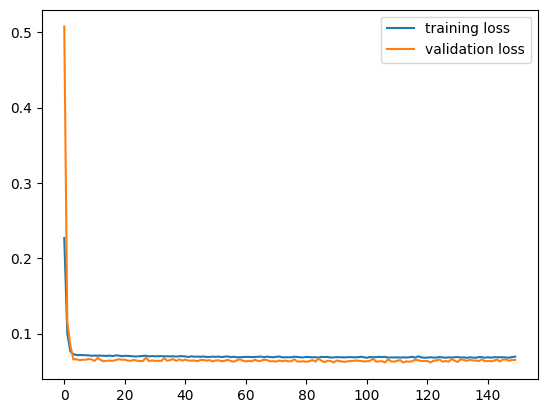

In [39]:
plt.plot(train_losses, label = 'training loss')
plt.plot(val_losses, label = 'validation loss')
plt.legend()
plt.show()

# Inspection Space

In [40]:
weather_cols = ['dewpoint_2m','relativehumidity_2m','temperature_2m',
                'apparent_temperature', 'precipitation', 'cloudcover', 'cloudcover_low',
                'cloudcover_mid', 'cloudcover_high', 'shortwave_radiation',
                'direct_radiation', 'diffuse_radiation', 'direct_normal_irradiance']
weather_dictionary = {col:[] for col in weather_cols}

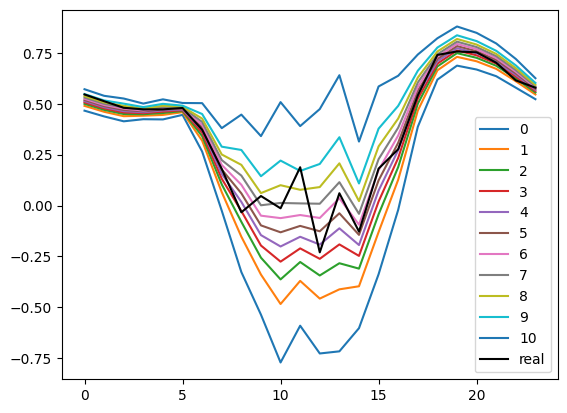

0.0407570203458723 0.1845326027523574


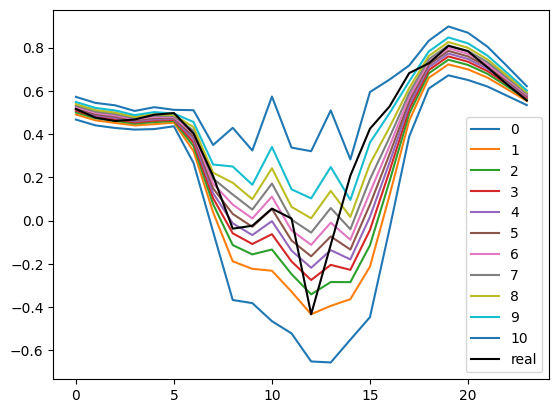

0.062352971621814614 0.17263082641323646


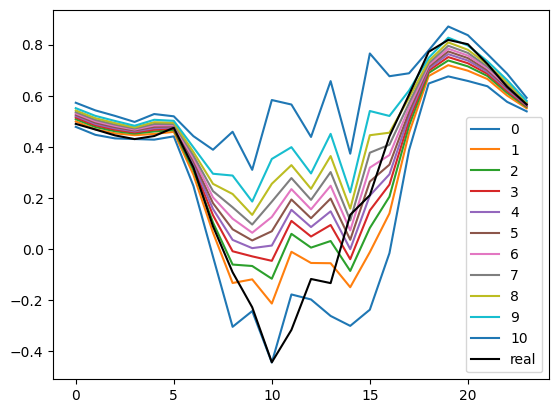

0.0797978381870796 -0.6981668090866597


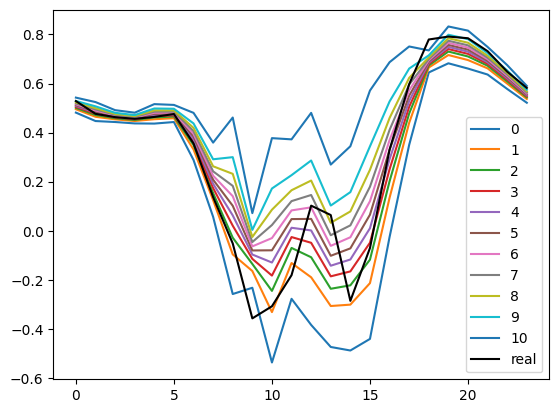

0.05699922865980269 -0.1064350676203194


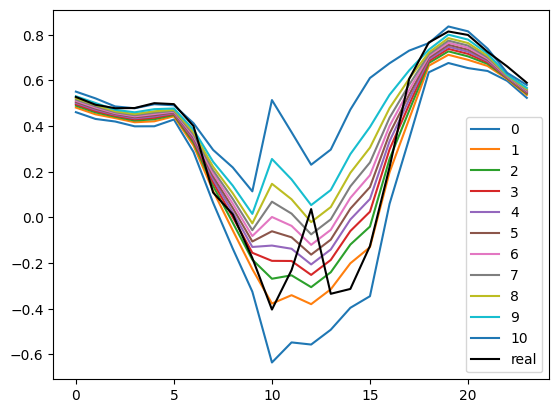

0.07178860877613578 -0.33418969831003786


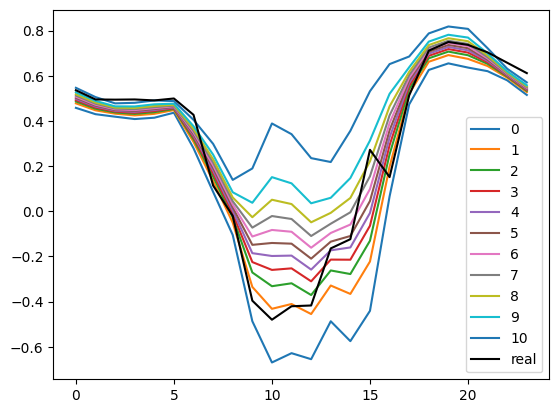

0.0738283139860592 -0.43507174584745156


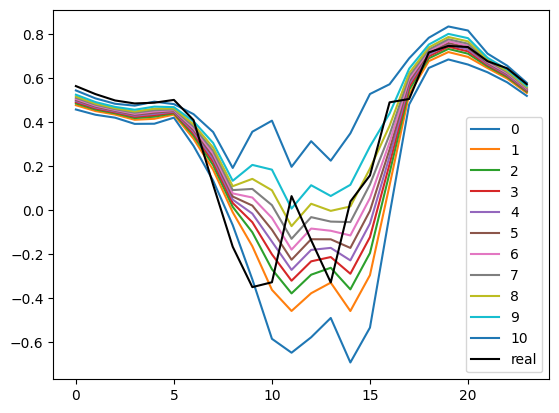

0.079355462009097 -0.5466234997992498


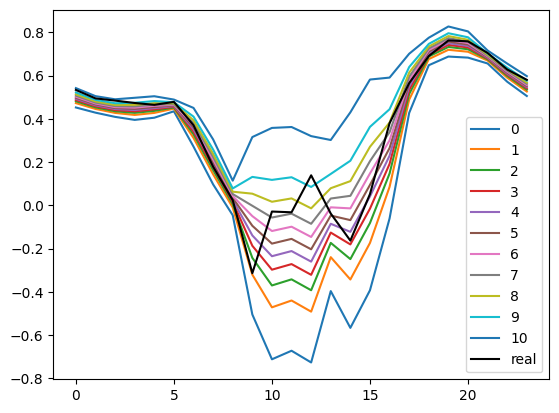

0.04229912934050469 0.017457781589900967


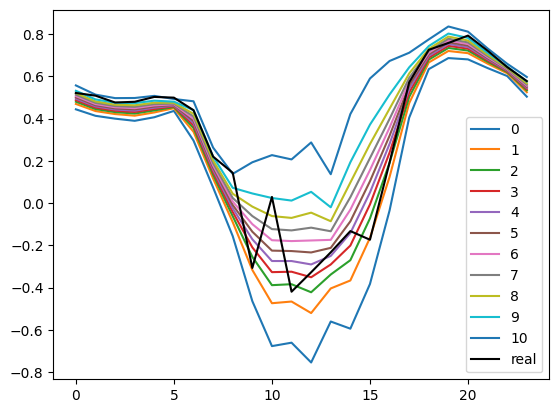

0.05739764946201801 -0.1107932281227142


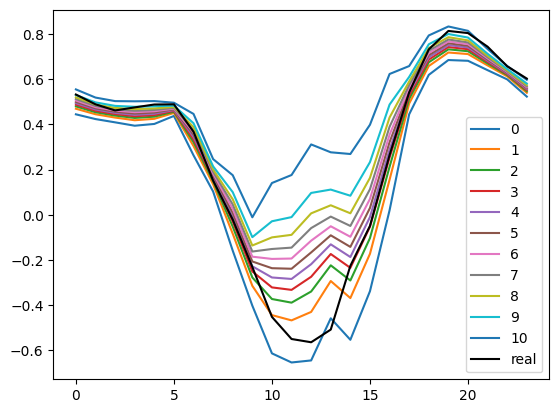

0.06316755878607028 -0.04918946242295208


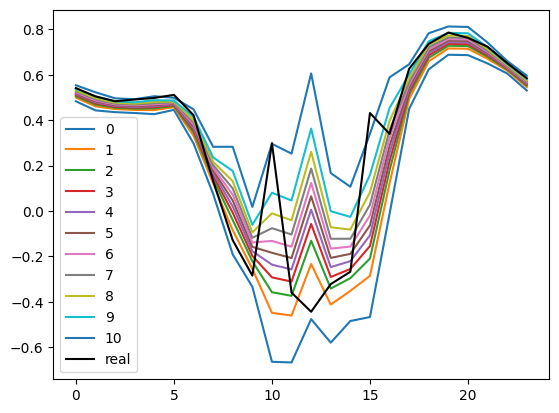

0.07782108833782184 -0.1652333966334194


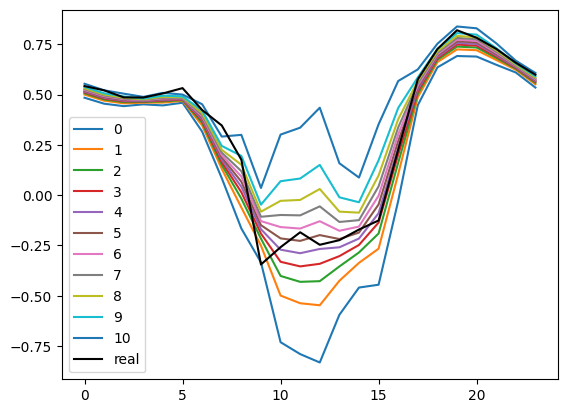

0.04157129436330807 0.24526961864355845


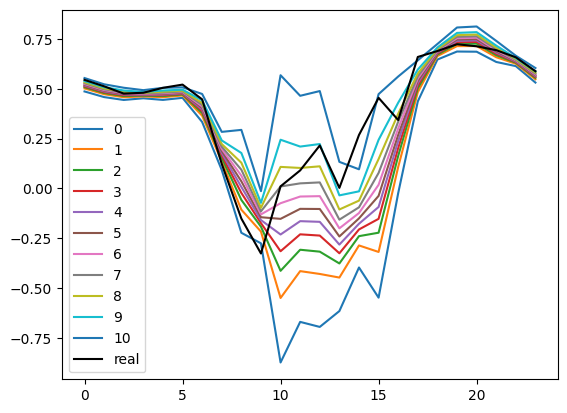

0.08075259559454744 -0.12853612762935507


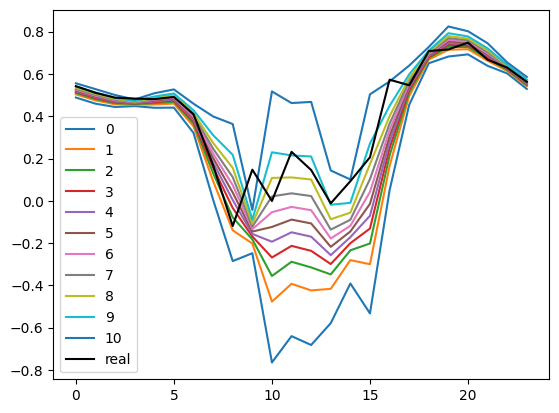

0.07219594313034876 -0.1288706491570879


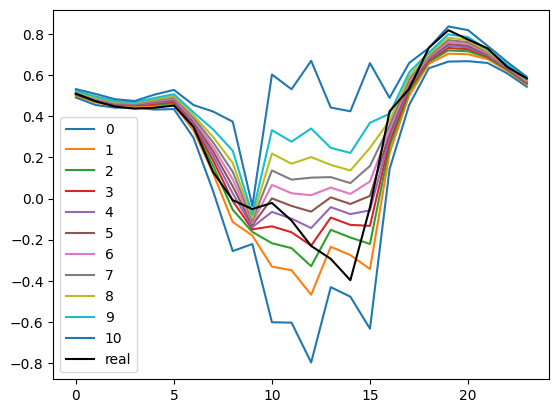

0.054131138604274015 -0.31777431116750754


In [41]:
daily_crps = []
daily_crpss = []
for month_prev, month, day in [(6,6,i) for i in range(19, 31)] + [(6,7,1),(7,7,2),(7,7,3)]:


  start_date = '2023-{:02d}-{:02d}'.format(month_prev, day - 1 if day != 1 else 30)
  end_date = '2023-{:02d}-{:02d}'.format(month, day)
  test_df = test_data[(test_data.time >= start_date + ' 01:00:00')
                    & (test_data.time <= end_date + ' 00:00:00')].drop(columns = 'time')

  X_test = test_df[[col for col in test_df.columns if col != 'value']]
  y_test = test_df.value
  X_test = torch.from_numpy(X_test.values).to(torch.float64)
  y_test = torch.from_numpy(y_test.values).to(torch.float64)

  preds = model(X_test)

  hourly_deviations = []
  meanies = []
  std_hour = X_test[:,-lookback_dim:].std(dim = 1).view(24,1)


  vals = []
  for i in range(0, 11):
    # q = i/10 if i not in [0,10] else (0.01 if i == 0 else 0.99)

    pred2 = preds[:,i] #+ (1 * std_hour) * torch.sqrt(torch.tensor(2)) * torch.erfinv(torch.tensor((2 * q) - 1))

    vals.append(pred2)
    plt.plot(pred2.detach().numpy(), label = str(i))

  plt.plot(y_test, color = 'black', label = 'real')
  plt.legend()
  plt.show()

  for col in weather_cols:
    weather_data = test_df[col].values
    weather_dictionary[col].append(test_df[col].std())


  pred = preds.detach().numpy()#torch.concat(vals, dim = 1).detach().numpy()

  # submission = pd.DataFrame(columns = ['timestamp']+['p' + str(i*10) for i in range(11)])
  # submission['timestamp'] = pd.date_range(start = '2023-06-{0:2d} 01:00:00'.format(day - 1),
  #                                         end =  '2023-06-{0:2d} 00:00:00'.format(day),
  #                                         freq='H',
  #                                         tz = states['ga']['local_time_zone']
  #                                         )

  # submission[['p' + str(i*10) for i in range(11)]] = pred



  obs = y_test.detach().numpy()
  fx_prob = torch.tensor([i for i in range(0,110,10)]).unsqueeze(0).repeat(24,1).numpy()
  crps, crpss, _ = crps_and_crpss_scores(obs, pred, start_date, end_date, state_location)
  print(crps, crpss)
  daily_crps.append(crps)
  daily_crpss.append(crpss)
  # submission.to_csv("/content/drive/MyDrive/net_load_forecasting/submissions/_new_model_June_{:02d}.csv".format(day))

# plt.plot(,daily_crps)
# plt.show()

## crpss


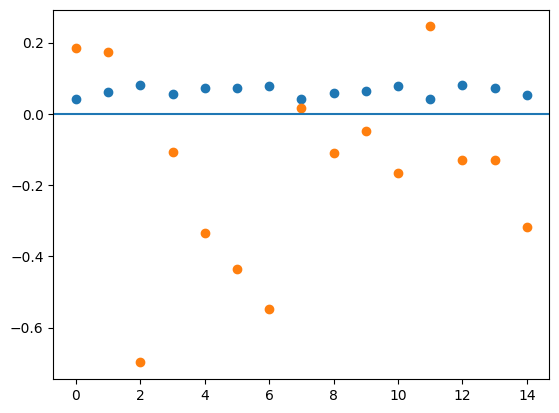

In [42]:
plt.scatter(range(len(daily_crps)), daily_crps)
plt.scatter(range(len(daily_crpss)), daily_crpss)
plt.axhline(0)
plt.show()

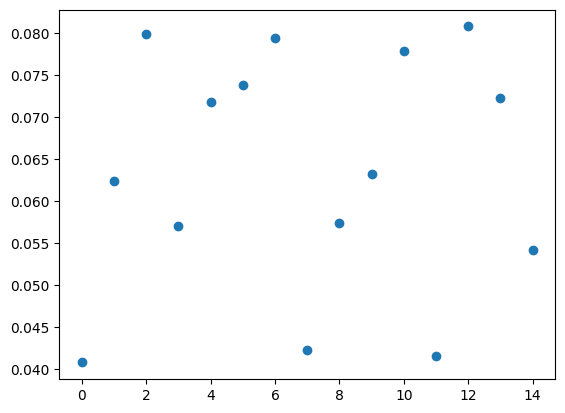

In [43]:
plt.scatter(range(len(daily_crps)), daily_crps)


<ipython-input-44-58bf7266af47>:7: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(weather_data / np.max(np.abs(weather_data)), label = col)


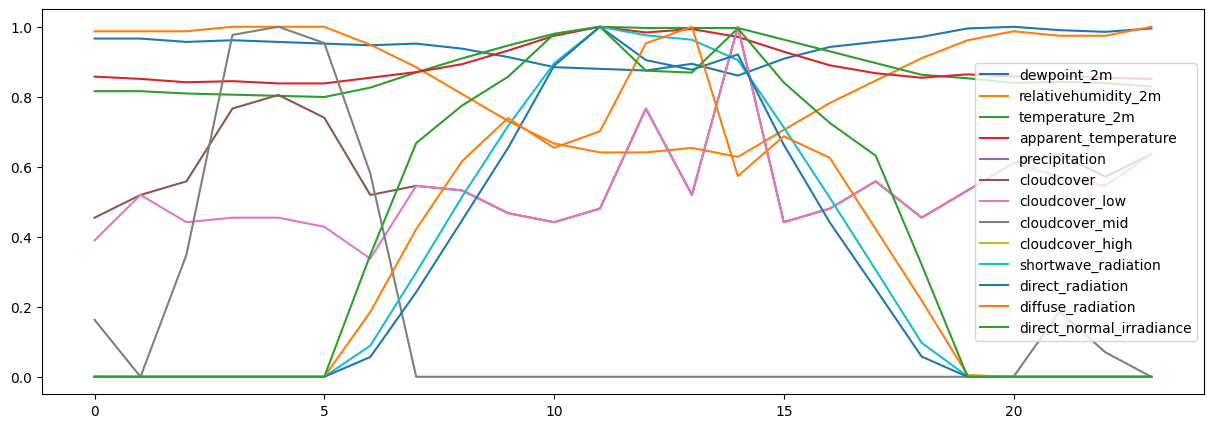

In [44]:
day = 23
test_df = test_data[(test_data.time >= '2023-06-{:02d} 01:00:00'.format(day - 1)) & (test_data.time <= '2023-06-{:02d} 00:00:00'.format(day))].drop(columns = 'time')
plt.figure(figsize = (15,5))
for col in weather_cols:
  weather_data = test_df[col].values
  weather_dictionary[col].append(test_df[col].std())
  plt.plot(weather_data / np.max(np.abs(weather_data)), label = col)

plt.legend()
plt.show()

<ipython-input-45-62c645e8ea18>:6: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(weather_data / np.max(np.abs(weather_data)), label = col)


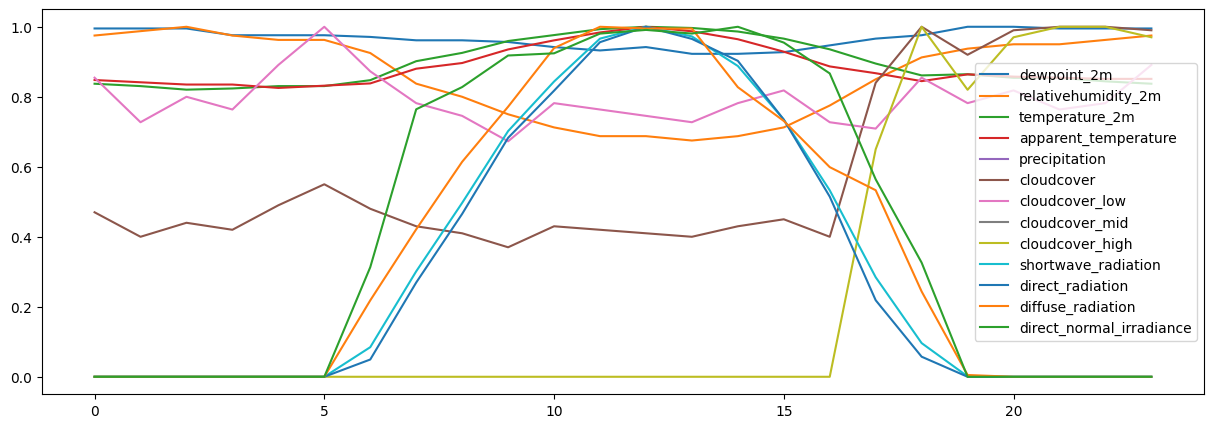

In [45]:
day = 24
test_df = test_data[(test_data.time >= '2023-06-{:02d} 01:00:00'.format(day - 1)) & (test_data.time <= '2023-06-{:02d} 00:00:00'.format(day))].drop(columns = 'time')
plt.figure(figsize = (15,5))
for col in weather_cols:
  weather_data = test_df[col].values
  plt.plot(weather_data / np.max(np.abs(weather_data)), label = col)

plt.legend()
plt.show()

In [46]:
# current_day = -1
# biases = []
# predictions = []
# observations = []
# for i in range(lookback_start, lookback_end + 1):
#   test_df = test_data[(-24 * (i) + 1):(-24 * (i) + 1) + 24].drop(columns = 'time')
#   X_test = test_df[[col for col in test_df.columns if col != 'value']]
#   y_test = test_df.value
#   X_test = torch.from_numpy(X_test.values).to(torch.float64)
#   y_test = torch.from_numpy(y_test.values).to(torch.float64)

#   preds = model(X_test)

#   predictions.append(preds)
#   observations.append(y_test)

# mean_pred = torch.zeros((24,1))
# mean_obs = torch.zeros((24,1))

# for i in range(lookback_dim):
#   mean_pred += predictions[i]
#   mean_obs += observations[i].view(24,1)

# mean_obs /= lookback_dim
# mean_pred /= lookback_dim

# test_df = test_data[-23-24:-23].drop(columns = 'time')
# X_test = test_df[[col for col in test_df.columns if col != 'value']]
# y_test = test_df.value
# X_test = torch.from_numpy(X_test.values).to(torch.float64)
# y_test = torch.from_numpy(y_test.values).to(torch.float64)

# preds = model(X_test)

# hourly_deviations = []
# meanies = []
# std_hour = X_test[:,-lookback_dim:].std(dim = 1).view(24,1)


# vals = []
# for i in range(0, 11):
#   q = i/10 if i not in [0,10] else (0.01 if i == 0 else 0.99)
#   bias = mean_pred - mean_obs
#   corrected_mean = preds - bias


#   pred2 = preds + std_hour * torch.sqrt(torch.tensor(2)) * torch.erfinv(torch.tensor((2 * q) - 1))

#   vals.append(pred2)
#   plt.plot(pred2.detach().numpy(), label = str(i))

# plt.legend()
# plt.show()

# pred = torch.concat(vals, dim = 1).detach().numpy()


# BIAS CORRECTION AND SUBMISSION

In [47]:
test_data[-23-24:-23]

,time,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,...,sunset,sunrise,hours,month,prev_2,prev_3,prev_4,prev_5,prev_6,prev_7
888,2023-07-08 01:00:00,NaN,24.3,72,18.9,25.3,0.0,53,36,0,...,0.300161,-0.250094,-0.442454,7,0.558298,0.557447,0.588936,0.525106,0.510638,0.542128
889,2023-07-08 02:00:00,NaN,24.2,73,19.0,25.3,0.0,100,40,0,...,0.300161,-0.250094,-0.404715,7,0.531915,0.519149,0.535319,0.484255,0.474043,0.510638
890,2023-07-08 03:00:00,NaN,23.9,72,18.5,24.8,0.0,100,43,0,...,0.300161,-0.250094,-0.366273,7,0.497872,0.492766,0.512341,0.471489,0.447660,0.487660
891,2023-07-08 04:00:00,NaN,23.8,70,18.0,24.6,0.0,100,42,0,...,0.300161,-0.250094,-0.327195,7,0.503830,0.473192,0.490213,0.467234,0.437447,0.483404
892,2023-07-08 05:00:00,NaN,23.9,72,18.6,24.8,0.0,100,43,0,...,0.300161,-0.250094,-0.287549,7,0.512341,0.495319,0.490213,0.464681,0.441702,0.480851
893,2023-07-08 06:00:00,NaN,23.5,75,18.8,24.3,0.0,100,41,0,...,0.300161,-0.250094,-0.247404,7,0.520000,0.517447,0.500426,0.485958,0.452766,0.491064
894,2023-07-08 07:00:00,NaN,23.8,72,18.5,24.8,0.0,92,42,0,...,0.300161,-0.250094,-0.206830,7,0.397447,0.371915,0.410213,0.417872,0.348936,0.409362
895,2023-07-08 08:00:00,NaN,25.6,63,18.0,25.5,0.0,51,44,0,...,0.300161,-0.250094,-0.165896,7,0.200000,0.145532,0.177872,0.244255,0.129362,0.167660
896,2023-07-08 09:00:00,NaN,26.5,60,18.1,26.2,0.0,52,41,0,...,0.300161,-0.250094,-0.124675,7,0.106383,0.131915,-0.062128,0.076596,-0.007659,-0.119149
897,2023-07-08 10:00:00,NaN,27.6,60,19.1,27.8,0.0,53,43,39,...,0.300161,-0.250094,-0.083237,7,-0.127659,0.217872,-0.228085,-0.173617,-0.051064,0.147234


In [48]:
test_df = test_data[-23-24-24:-23-24]#.drop(columns = 'time')

In [49]:
current_day = -1
biases = []
predictions = []
observations = []
for i in range(lookback_start, lookback_end + 1):
  test_df = test_data[(-24 * (i) + 1):(-24 * (i) + 1) + 24].drop(columns = 'time')
  X_test = test_df[[col for col in test_df.columns if col != 'value']]
  y_test = test_df.value
  X_test = torch.from_numpy(X_test.values).to(torch.float64)
  y_test = torch.from_numpy(y_test.values).to(torch.float64)

  preds = model(X_test)

  predictions.append(preds)
  observations.append(y_test)

mean_pred = torch.zeros((24,11))
mean_obs = torch.zeros((24,1))

for i in range(lookback_dim):
  mean_pred += predictions[i]
  mean_obs += observations[i].view(24,1)

mean_obs /= lookback_dim
mean_pred /= lookback_dim

In [50]:
test_data[-23-24:-23]

,time,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,...,sunset,sunrise,hours,month,prev_2,prev_3,prev_4,prev_5,prev_6,prev_7
888,2023-07-08 01:00:00,NaN,24.3,72,18.9,25.3,0.0,53,36,0,...,0.300161,-0.250094,-0.442454,7,0.558298,0.557447,0.588936,0.525106,0.510638,0.542128
889,2023-07-08 02:00:00,NaN,24.2,73,19.0,25.3,0.0,100,40,0,...,0.300161,-0.250094,-0.404715,7,0.531915,0.519149,0.535319,0.484255,0.474043,0.510638
890,2023-07-08 03:00:00,NaN,23.9,72,18.5,24.8,0.0,100,43,0,...,0.300161,-0.250094,-0.366273,7,0.497872,0.492766,0.512341,0.471489,0.447660,0.487660
891,2023-07-08 04:00:00,NaN,23.8,70,18.0,24.6,0.0,100,42,0,...,0.300161,-0.250094,-0.327195,7,0.503830,0.473192,0.490213,0.467234,0.437447,0.483404
892,2023-07-08 05:00:00,NaN,23.9,72,18.6,24.8,0.0,100,43,0,...,0.300161,-0.250094,-0.287549,7,0.512341,0.495319,0.490213,0.464681,0.441702,0.480851
893,2023-07-08 06:00:00,NaN,23.5,75,18.8,24.3,0.0,100,41,0,...,0.300161,-0.250094,-0.247404,7,0.520000,0.517447,0.500426,0.485958,0.452766,0.491064
894,2023-07-08 07:00:00,NaN,23.8,72,18.5,24.8,0.0,92,42,0,...,0.300161,-0.250094,-0.206830,7,0.397447,0.371915,0.410213,0.417872,0.348936,0.409362
895,2023-07-08 08:00:00,NaN,25.6,63,18.0,25.5,0.0,51,44,0,...,0.300161,-0.250094,-0.165896,7,0.200000,0.145532,0.177872,0.244255,0.129362,0.167660
896,2023-07-08 09:00:00,NaN,26.5,60,18.1,26.2,0.0,52,41,0,...,0.300161,-0.250094,-0.124675,7,0.106383,0.131915,-0.062128,0.076596,-0.007659,-0.119149
897,2023-07-08 10:00:00,NaN,27.6,60,19.1,27.8,0.0,53,43,39,...,0.300161,-0.250094,-0.083237,7,-0.127659,0.217872,-0.228085,-0.173617,-0.051064,0.147234


In [51]:
test_data[-23-24:-23]

,time,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,...,sunset,sunrise,hours,month,prev_2,prev_3,prev_4,prev_5,prev_6,prev_7
888,2023-07-08 01:00:00,NaN,24.3,72,18.9,25.3,0.0,53,36,0,...,0.300161,-0.250094,-0.442454,7,0.558298,0.557447,0.588936,0.525106,0.510638,0.542128
889,2023-07-08 02:00:00,NaN,24.2,73,19.0,25.3,0.0,100,40,0,...,0.300161,-0.250094,-0.404715,7,0.531915,0.519149,0.535319,0.484255,0.474043,0.510638
890,2023-07-08 03:00:00,NaN,23.9,72,18.5,24.8,0.0,100,43,0,...,0.300161,-0.250094,-0.366273,7,0.497872,0.492766,0.512341,0.471489,0.447660,0.487660
891,2023-07-08 04:00:00,NaN,23.8,70,18.0,24.6,0.0,100,42,0,...,0.300161,-0.250094,-0.327195,7,0.503830,0.473192,0.490213,0.467234,0.437447,0.483404
892,2023-07-08 05:00:00,NaN,23.9,72,18.6,24.8,0.0,100,43,0,...,0.300161,-0.250094,-0.287549,7,0.512341,0.495319,0.490213,0.464681,0.441702,0.480851
893,2023-07-08 06:00:00,NaN,23.5,75,18.8,24.3,0.0,100,41,0,...,0.300161,-0.250094,-0.247404,7,0.520000,0.517447,0.500426,0.485958,0.452766,0.491064
894,2023-07-08 07:00:00,NaN,23.8,72,18.5,24.8,0.0,92,42,0,...,0.300161,-0.250094,-0.206830,7,0.397447,0.371915,0.410213,0.417872,0.348936,0.409362
895,2023-07-08 08:00:00,NaN,25.6,63,18.0,25.5,0.0,51,44,0,...,0.300161,-0.250094,-0.165896,7,0.200000,0.145532,0.177872,0.244255,0.129362,0.167660
896,2023-07-08 09:00:00,NaN,26.5,60,18.1,26.2,0.0,52,41,0,...,0.300161,-0.250094,-0.124675,7,0.106383,0.131915,-0.062128,0.076596,-0.007659,-0.119149
897,2023-07-08 10:00:00,NaN,27.6,60,19.1,27.8,0.0,53,43,39,...,0.300161,-0.250094,-0.083237,7,-0.127659,0.217872,-0.228085,-0.173617,-0.051064,0.147234


In [52]:
# test_data.prev_4 = test_data.prev_4.fillna(0.58340425)

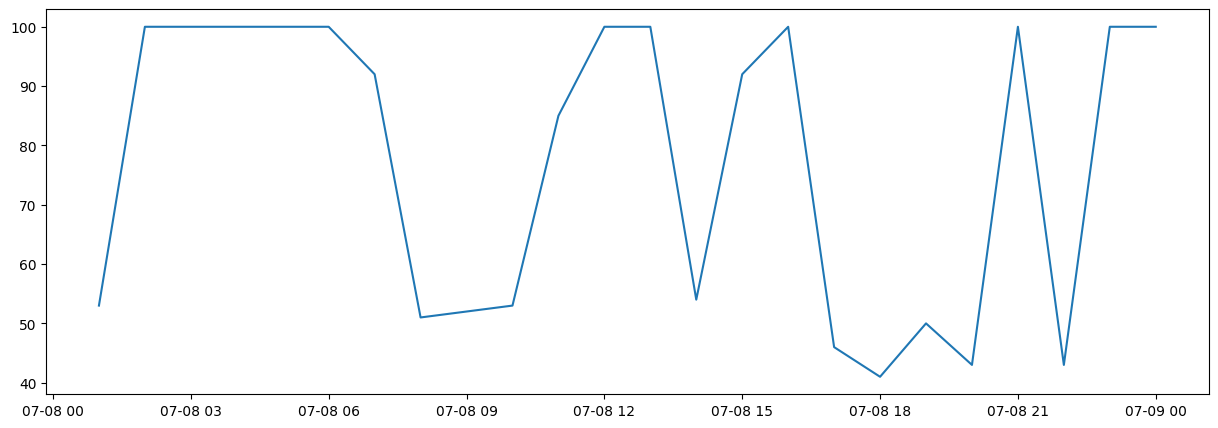

In [65]:
plt.figure(figsize = (15,5))
plt.plot(test_data[-23-24:-23].time,test_data[-23-24:-23].cloudcover)

In [67]:
test_data[-23-24:-23][['time','cloudcover']]

,time,cloudcover
888,2023-07-08 01:00:00,53
889,2023-07-08 02:00:00,100
890,2023-07-08 03:00:00,100
891,2023-07-08 04:00:00,100
892,2023-07-08 05:00:00,100
893,2023-07-08 06:00:00,100
894,2023-07-08 07:00:00,92
895,2023-07-08 08:00:00,51
896,2023-07-08 09:00:00,52
897,2023-07-08 10:00:00,53


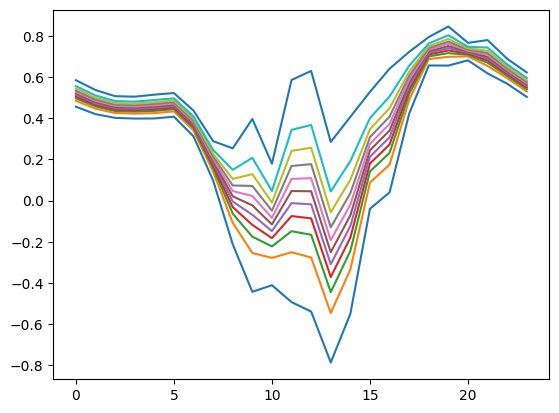

In [54]:
# j = 1
# trial_x, trial_y = X_test[-24 * (j): -24 * (j-1)], y_test[-24 * (j): -24 * (j-1)]

test_df = test_data[-23-24:-23].drop(columns = 'time')
X_test = test_df[[col for col in test_df.columns if col != 'value']]
y_test = test_df.value
X_test = torch.from_numpy(X_test.values).to(torch.float64)
y_test = torch.from_numpy(y_test.values).to(torch.float64)

preds = model(X_test)#torch.from_numpy(X).to(torch.float64))#.shape

hourly_deviations = []
meanies = []
std_hour = X_test[:,-lookback_dim:].std(dim = 1).view(24,1)#new_df[new_df['hour'] == float(i)]['value'].std()


vals = []
# for i in range(0, 11):
#   q = i/10 if i not in [0,10] else (0.01 if i == 0 else 0.99)
#   bias = mean_pred - mean_obs
#   corrected_mean = preds - bias#(preds - mean)


#   pred2 = preds +  (2 * std_hour) * torch.sqrt(torch.tensor(2)) * torch.erfinv(torch.tensor((2 * q) - 1))

#   vals.append(pred2)
plt.plot(preds.detach().numpy(), label = str(i))

# plt.legend()
# plt.show()

pred = preds.detach().numpy()#torch.concat(vals, dim = 1).detach().numpy()

# Submission Block

In [55]:
from datetime import datetime

In [63]:
# submission = pd.DataFrame(columns = ['timestamp']+['p' + str(i*10) for i in range(11)])
# submission['timestamp'] = pd.date_range(start = '2023-07-08 01:00:00',
#                                          end =  '2023-07-09 00:00:00',
#                                          freq='H',
#                                          tz = states[state_location]['local_time_zone']
#                                          )
# submission[['p' + str(i*10) for i in range(11)]] = pred

# submission.to_csv("/content/drive/MyDrive/net_load_forecasting/submissions/{}_pytorch2_submission_{}.csv".format(state_location, datetime.now()))

# upload_function(submission.set_index('timestamp'),state_location)

#Data Playground/ Comment everything when submitting

In [57]:
vals_per_hour = []
if state_location == 'ga':
  temp_df = training_data[((training_data['time'] <= '2022-10-01 00:00:00') | (training_data['time'] >= '2022-10-31 00:00:00'))]#.drop(columns = 'time')
if state_location == 'tx':
  temp_df = training_data[((training_data['time'] >= '2022-06-01 00:00:00') & (training_data['time'] <= '2022-09-01 00:00:00'))]#.drop(columns = 'time')
if state_location == 'or':
  temp_df = training_data[((training_data['time'].dt.month >= 5) & (training_data['time'].dt.month <= 9))]#.drop(columns = 'time')
if state_location == 'hi':
  # temp_df = training_data[((training_data['time'] <= '2023-03-14 00:00:00') | (training_data['time'] >= '2022-03-27 00:00:00'))]#.drop(columns = 'time')
  temp_df = training_data[((training_data['time'].dt.month >= 5) & (training_data['time'].dt.month <= 9))]#.drop(columns = 'time')


for hour in range(24):
  vals_per_hour.append(temp_df[(temp_df.time.dt.hour == hour) & temp_df.value != 0].value.values)


In [58]:

len(vals_per_hour[0])

184

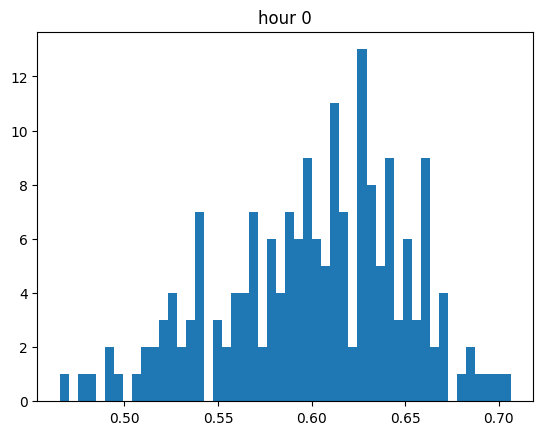

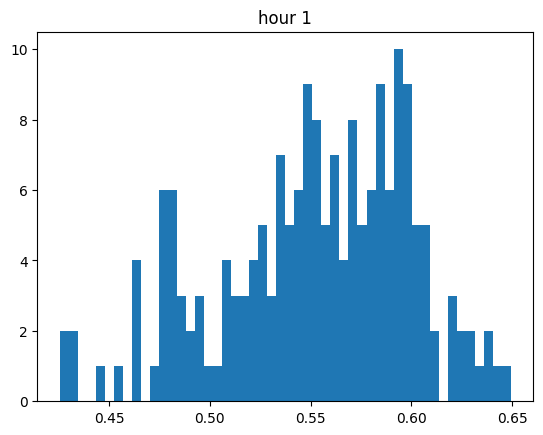

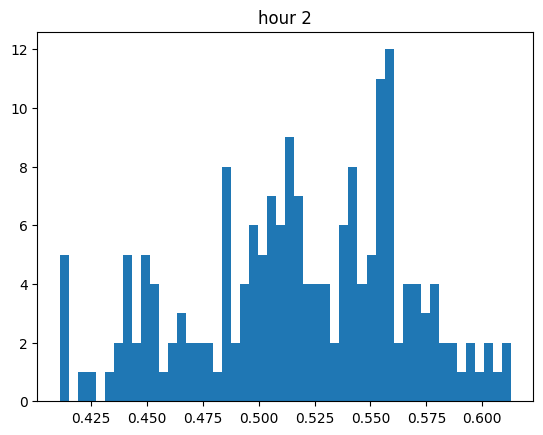

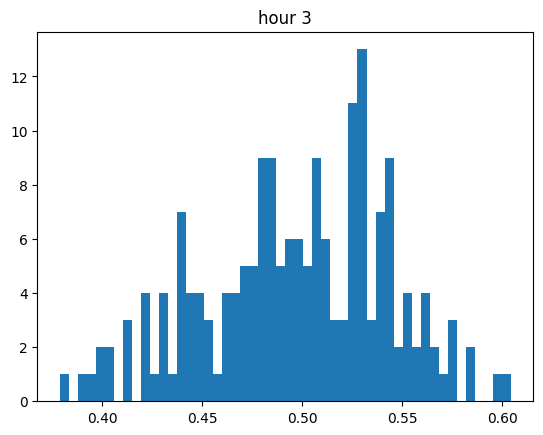

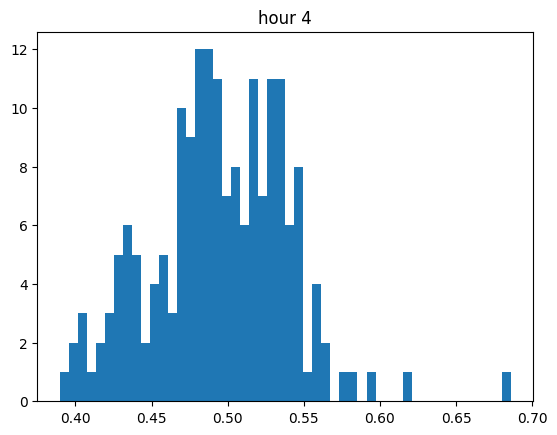

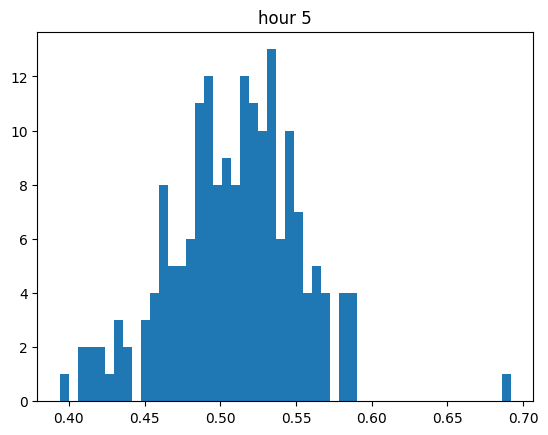

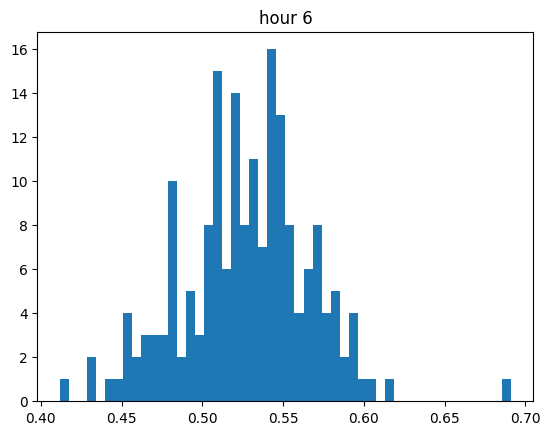

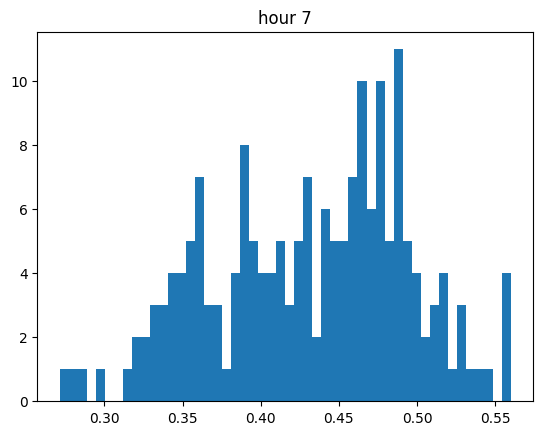

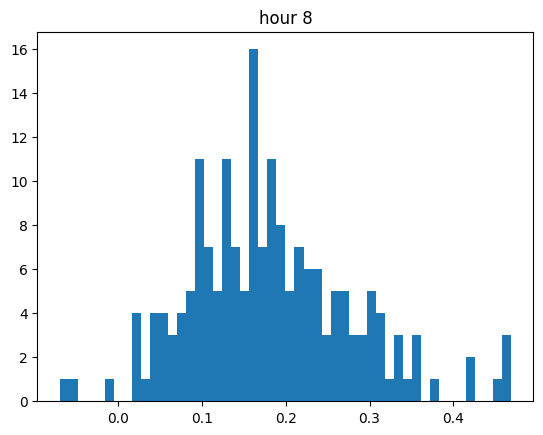

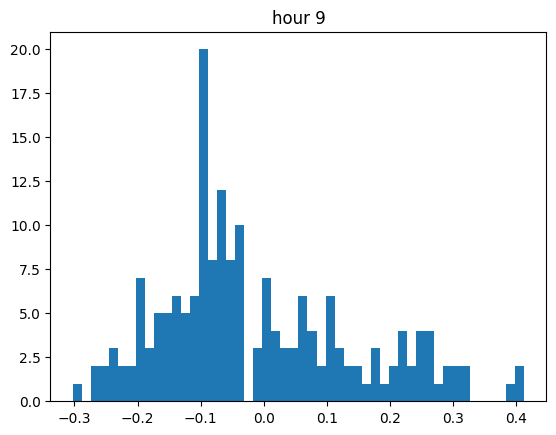

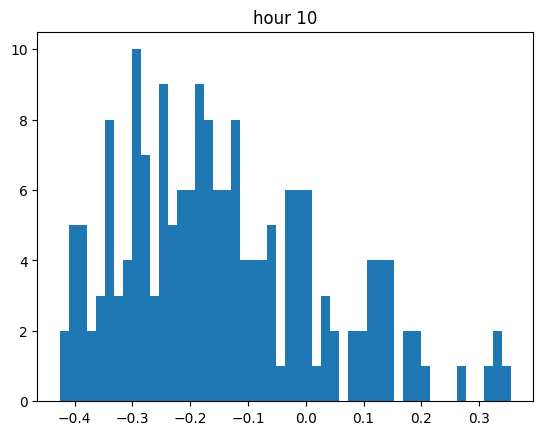

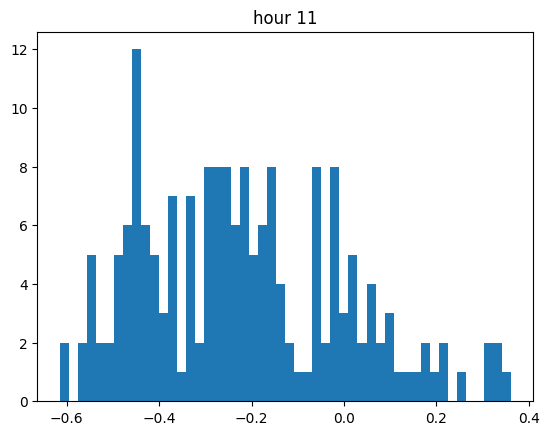

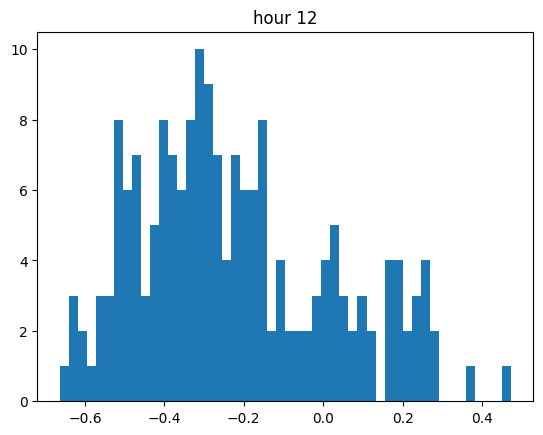

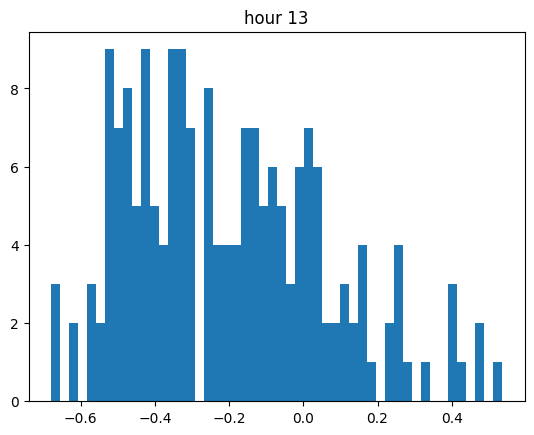

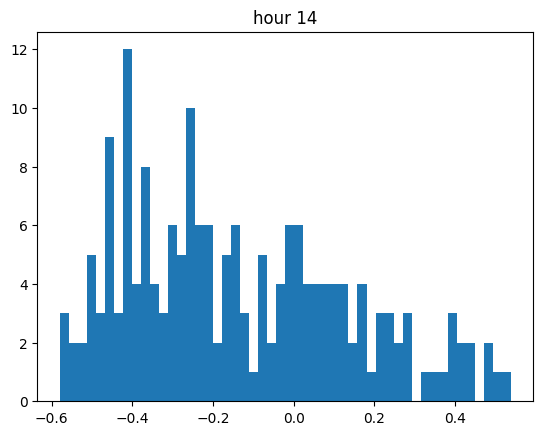

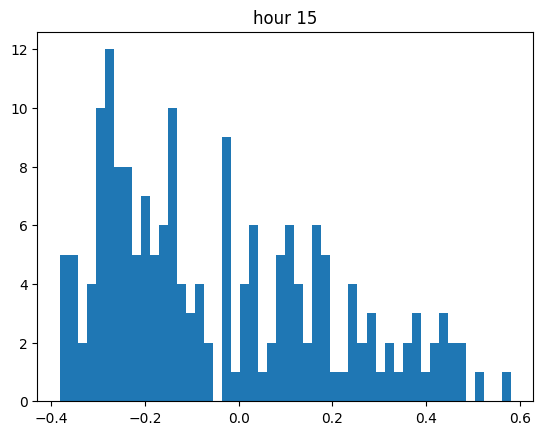

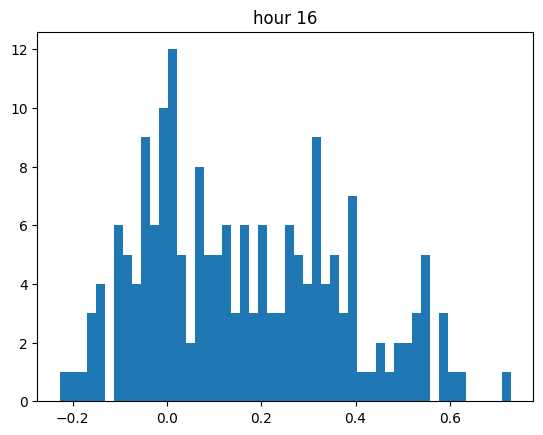

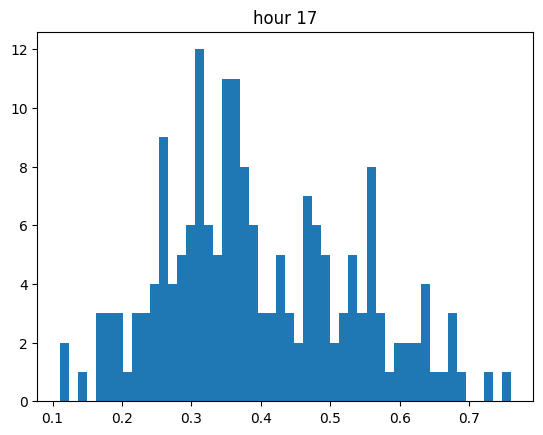

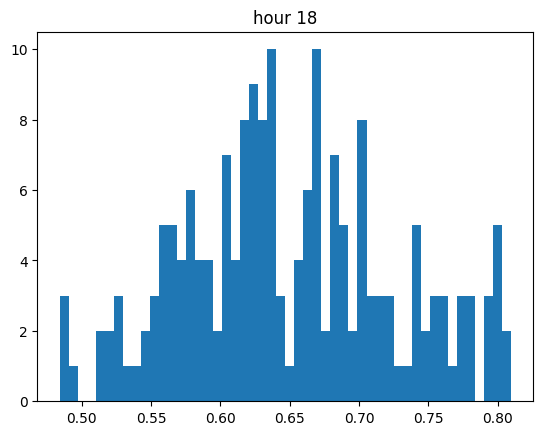

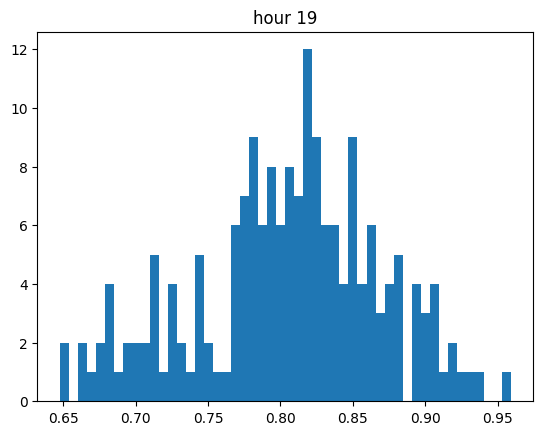

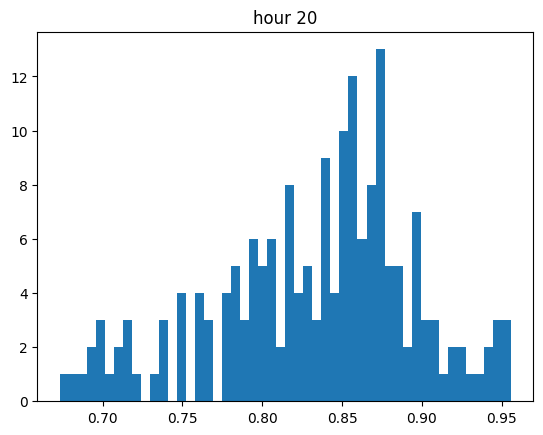

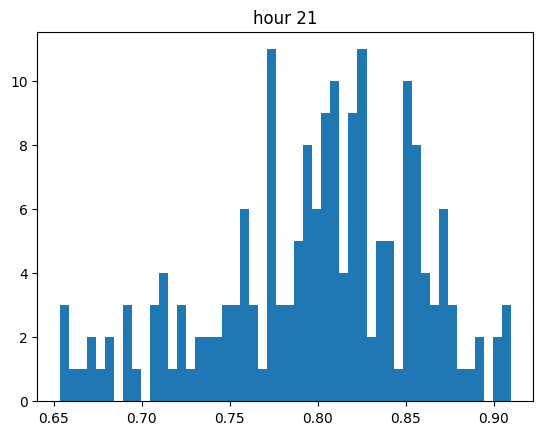

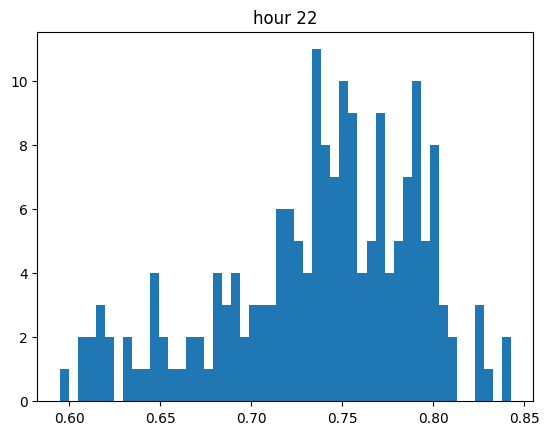

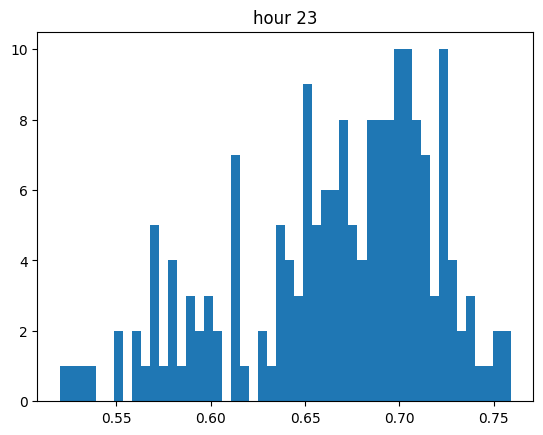

In [59]:
for i in range(24):
  plt.hist(vals_per_hour[i], bins = 50)
  plt.title('hour ' + str(i))
  plt.show()

In [60]:
sum(training_data.value.isna())

0

In [61]:
test_data[test_data.values.isna()]

AttributeError: ignored